In [ ]:
!pip install -q kagglehub
import kagglehub
import os

dataset_path = kagglehub.dataset_download("behrad3d/nasa-cmaps")
print("Dataset path:", dataset_path)

os.listdir(dataset_path)


100%|██████████| 12.3M/12.3M [00:00<00:00, 51.2MB/s]

Extracting files...


Dataset path: /root/.cache/kagglehub/datasets/behrad3d/nasa-cmaps/versions/1


['CMaps']

In [ ]:
cmaps_path = os.path.join(dataset_path, "CMaps")
os.listdir(cmaps_path)


['train_FD002.txt',
 'test_FD004.txt',
 'RUL_FD002.txt',
 'test_FD003.txt',
 'train_FD003.txt',
 'train_FD004.txt',
 'RUL_FD001.txt',
 'test_FD001.txt',
 'RUL_FD004.txt',
 'Damage Propagation Modeling.pdf',
 'readme.txt',
 'test_FD002.txt',
 'train_FD001.txt',
 'RUL_FD003.txt',
 'x.txt']

In [ ]:
train_file = os.path.join(cmaps_path, "train_FD001.txt")
test_file  = os.path.join(cmaps_path, "test_FD001.txt")
rul_file   = os.path.join(cmaps_path, "RUL_FD001.txt")


In [ ]:
import pandas as pd

column_names = (
    ["engine_id", "cycle"] +
    [f"op_setting_{i}" for i in range(1, 4)] +
    [f"sensor_{i}" for i in range(1, 22)]
)

train_df = pd.read_csv(
    train_file,
    sep=" ",
    header=None
)

train_df = train_df.iloc[:, :26]
train_df.columns = column_names

train_df.head()


,engine_id,cycle,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [ ]:
rul = train_df.groupby("engine_id")["cycle"].max().reset_index()
rul.columns = ["engine_id", "max_cycle"]

train_df = train_df.merge(rul, on="engine_id")
train_df["RUL"] = train_df["max_cycle"] - train_df["cycle"]

train_df.head()


,engine_id,cycle,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,max_cycle,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,192,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,192,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,192,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,192,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,192,187


In [ ]:
sensor_cols = [col for col in train_df.columns if "sensor" in col]
data = train_df[sensor_cols]


In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)


In [ ]:
import numpy as np
SEQUENCE_LENGTH = 30

def create_sequences(data, seq_len):
    sequences = []
    for i in range(len(data) - seq_len):
        sequences.append(data[i:i + seq_len])
    return np.array(sequences)

X_sequences = create_sequences(data_scaled, SEQUENCE_LENGTH)

print("Sequence shape:", X_sequences.shape)


Sequence shape: (20601, 30, 21)


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

n_features = X_sequences.shape[2]

model = models.Sequential([
    layers.Input(shape=(SEQUENCE_LENGTH, n_features)),

    layers.LSTM(64, return_sequences=True),
    layers.LSTM(32, return_sequences=False),

    layers.RepeatVector(SEQUENCE_LENGTH),

    layers.LSTM(32, return_sequences=True),
    layers.LSTM(64, return_sequences=True),

    layers.TimeDistributed(layers.Dense(n_features))
])

model.compile(
    optimizer="adam",
    loss="mse"
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 64)         │        22,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 30, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 30, 32)         │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 30, 64)         │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 30, 21)         │         1,365 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,949 (269.33 KB)

 Trainable params: 68,949 (269.33 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    X_sequences,
    X_sequences,
    epochs=10,
    batch_size=128,
    validation_split=0.1,
    shuffle=True
)


Epoch 1/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 26s 130ms/step - loss: 0.0423 - val_loss: 0.0075
Epoch 2/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 17s 119ms/step - loss: 0.0076 - val_loss: 0.0065
Epoch 3/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 17s 116ms/step - loss: 0.0070 - val_loss: 0.0064
Epoch 4/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 18s 123ms/step - loss: 0.0070 - val_loss: 0.0064
Epoch 5/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 17s 120ms/step - loss: 0.0069 - val_loss: 0.0062
Epoch 6/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 17s 116ms/step - loss: 0.0064 - val_loss: 0.0054
Epoch 7/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 21s 116ms/step - loss: 0.0059 - val_loss: 0.0052
Epoch 8/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 17s 120ms/step - loss: 0.0055 - val_loss: 0.0046
Epoch 9/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 20s 116ms/step - loss: 0.0049 - val_loss: 0.0045
Epoch 10/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - loss: 0.0047 - val_loss: 0.0044


In [ ]:
X_pred = model.predict(X_sequences)

reconstruction_error = np.mean(
    np.square(X_sequences - X_pred),
    axis=(1, 2)
)


644/644 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step


In [ ]:
threshold = np.mean(reconstruction_error) + 3 * np.std(reconstruction_error)
print("Anomaly threshold:", threshold)


Anomaly threshold: 0.011977402507358105


In [ ]:
anomalies = reconstruction_error > threshold

print("Total anomalies detected:", np.sum(anomalies))


Total anomalies detected: 401


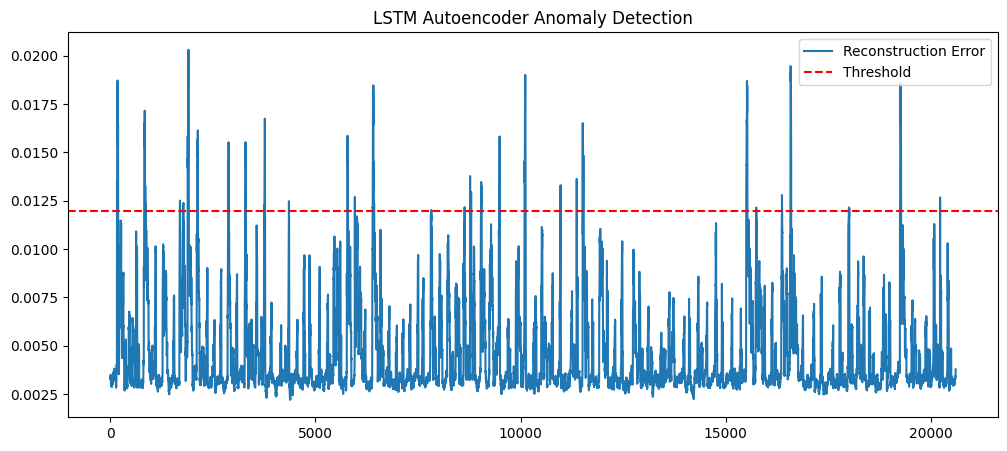

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(reconstruction_error, label="Reconstruction Error")
plt.axhline(threshold, color="red", linestyle="--", label="Threshold")
plt.legend()
plt.title("LSTM Autoencoder Anomaly Detection")
plt.show()


In [ ]:
os.makedirs("/content/models", exist_ok=True)
model.save("/content/models/lstm_anomaly_detector.keras")


In [ ]:
labels = train_df["RUL"].values[SEQUENCE_LENGTH:]
true_labels = labels <= 30  # True = anomaly


In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true_labels, anomalies)
cm


array([[17100,   401],
       [ 3100,     0]])

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(true_labels, anomalies))


              precision    recall  f1-score   support

       False       0.85      0.98      0.91     17501
        True       0.00      0.00      0.00      3100

    accuracy                           0.83     20601
   macro avg       0.42      0.49      0.45     20601
weighted avg       0.72      0.83      0.77     20601



In [ ]:
from sklearn.metrics import roc_auc_score

roc_auc = roc_auc_score(true_labels, reconstruction_error)
print("ROC-AUC:", roc_auc)


ROC-AUC: 0.4150970912261234


In [ ]:
thresholds = np.linspace(
    reconstruction_error.min(),
    reconstruction_error.max(),
    50
)

from sklearn.metrics import f1_score

f1_scores = []

for t in thresholds:
    preds = reconstruction_error > t
    f1_scores.append(f1_score(true_labels, preds))

best_t = thresholds[np.argmax(f1_scores)]
print("Best Threshold:", best_t)


Best Threshold: 0.0029490027588636885
